In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_rel

from plm_subnetworks.dataset.cath_dataset import get_cath_db
from plm_subnetworks.dataset import data_io
from plm_subnetworks.dataset.constants import SUBNETWORK_LEVELS_FOR_PLOTTING, PRETTY_NAMES

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from plm_subnetworks.dataset.data_paths import ESM_TMALIGN_METRICS
RUN_DIR_PREFIX = "../results/subnetworks" # Change this to runs/ if evaluating new trained subnetworks


In [2]:
db = get_cath_db()

In [3]:
SEQ_SUPPRESSION_METADATA_PATH = "../results/metadata.csv"
SEQ_SUPPRESSION_METADATA_DF = pd.read_csv(SEQ_SUPPRESSION_METADATA_PATH) 

ESM_GT_METRICS_DF = pd.read_csv(ESM_TMALIGN_METRICS)
ESM_GT_METRICS_DF = data_io.hydrate_df_with_cath_terms(ESM_GT_METRICS_DF, db)

In [4]:
categories = [
    "residue",
    "cath_class_code",
    "cath_architecture_code",
    "cath_topology_code",
    "cath_homologous_superfamily_code",
    "random_seq",   
]

SMALL = 10
MEDIUM = 17
LARGE = 25

In [5]:
def get_random_model_performance(df, dir):
    run_dir = f"{RUN_DIR_PREFIX}/{dir}"
        
    suppressed_id_path = f"{run_dir}/random_supp_ids.txt"
    with open(suppressed_id_path, "r") as f:
        suppressed_ids = f.read().splitlines()
    print("Loaded suppressed ids:", len(suppressed_ids))
    
    supp_df = df[df["cath_id"].isin(suppressed_ids)]
    maint_df = df[~df["cath_id"].isin(suppressed_ids)]
    
    suppression_gt = ESM_GT_METRICS_DF[ESM_GT_METRICS_DF["cath_id"].isin(suppressed_ids)]
    maintenance_gt = ESM_GT_METRICS_DF[~ESM_GT_METRICS_DF["cath_id"].isin(suppressed_ids)]


    return supp_df, maint_df, suppression_gt, maintenance_gt

    

In [6]:
df_list_all = []
names_all = []
targets_all = []
types_all = []
sizes_all = []
catnames_all = []

for CATEGORY in categories:
    subset = SEQ_SUPPRESSION_METADATA_DF[SEQ_SUPPRESSION_METADATA_DF["category"] == CATEGORY]
    models = list(zip(subset["run_name"], subset["epoch"], subset["target"], subset["type"], subset["size"]))
    
    for DIR, EPOCH, TARGET, TYPE, SIZE in models:

        names_all.append(DIR)
        targets_all.append(TARGET)
        types_all.append(TYPE)
        sizes_all.append(SIZE)
        catnames_all.append(CATEGORY)

        RUN_DIR = f"{RUN_DIR_PREFIX}/{DIR}"

        pred_tm_scores = f"{RUN_DIR}/tmalign.csv"

        try:
            SUBNETWORK_DF=pd.read_csv(pred_tm_scores)
        except Exception as e:
            print("!!! MISSING !!!", DIR, EPOCH)
            continue
        SUBNETWORK_DF = data_io.hydrate_df_with_cath_terms(SUBNETWORK_DF, db)        
        df_list_all.append((SUBNETWORK_DF, ESM_GT_METRICS_DF))


In [7]:
def plot_metric_deltas_one_col(
    dataframes, labels, targets, types, sizes, catnames,
    dpi=100, fontsize=20, savepath=None, colors=None
):
    metrics = ["TM-score", "RMSD", "pLDDT"]
    CONDITION_COLOR = {"Suppression": "tomato", "Maintenance": "royalblue"}
    SIZE_MAP = {SMALL: 100, MEDIUM: 225, LARGE: 400}
    records = []

    for (df_sub, df_esm), label, target, type_, size, catname in zip(dataframes, labels, targets, types, sizes, catnames):
        # Filter to common CATH IDs
        common_ids = set(df_sub["cath_id"]).intersection(df_esm["cath_id"])
        df_sub = df_sub[df_sub["cath_id"].isin(common_ids)]
        df_esm = df_esm[df_esm["cath_id"].isin(common_ids)]

        # Handle special category logic
        _catname = catname
        if catname == "residue":
            catname = "cath_class_code"
            target = "1" if "cath_class_code" == "1" else "2"
        if catname == "random_seq":
            sub_supp, sub_maint, esm_supp, esm_maint = get_random_model_performance(df_sub, label)
        else:
            sub_supp = df_sub[df_sub[catname] == target]
            sub_maint = df_sub[df_sub[catname] != target]
            esm_supp = df_esm[df_esm[catname] == target]
            esm_maint = df_esm[df_esm[catname] != target]

        marker_size = SMALL if size < 100 else MEDIUM if size <= 1000 else LARGE

        for metric in metrics:
            if metric not in sub_supp.columns:
                continue

            supp_merged = pd.merge(sub_supp[["cath_id", metric]], esm_supp[["cath_id", metric]], on="cath_id", suffixes=("_sub", "_esm"))
            maint_merged = pd.merge(sub_maint[["cath_id", metric]], esm_maint[["cath_id", metric]], on="cath_id", suffixes=("_sub", "_esm"))

            delta_supp = supp_merged[f"{metric}_sub"] - supp_merged[f"{metric}_esm"]
            delta_maint = maint_merged[f"{metric}_sub"] - maint_merged[f"{metric}_esm"]

            supp_significance = ttest_rel(supp_merged[f"{metric}_sub"], supp_merged[f"{metric}_esm"])[1] < 0.05
            maint_significance = ttest_rel(maint_merged[f"{metric}_sub"], maint_merged[f"{metric}_esm"])[1] < 0.05

            records.extend([
                {
                    "Type": type_.strip().lower(),
                    "Category": SUBNETWORK_LEVELS_FOR_PLOTTING.get(_catname, _catname),
                    "Metric": metric,
                    "Condition": "Suppression",
                    "Δ Value": delta_supp.mean(),
                    "Size": marker_size,
                    "Significant": supp_significance,
                },
                {
                    "Type": type_.strip().lower(),
                    "Category": SUBNETWORK_LEVELS_FOR_PLOTTING.get(_catname, _catname),
                    "Metric": metric,
                    "Condition": "Maintenance",
                    "Δ Value": delta_maint.mean(),
                    "Size": marker_size,
                    "Significant": maint_significance,
                }
            ])

    df = pd.DataFrame(records)

    # Create plot
    fig, axs = plt.subplots(1, 3, figsize=(22, 9), dpi=dpi)
    for i, metric in enumerate(metrics):
        ax = axs[i]
        metric_df = df[df["Metric"] == metric]
        for condition in ["Suppression", "Maintenance"]:
            cond_df = metric_df[metric_df["Condition"] == condition]
            linewidths = [2.5 if sig else 0.5 for sig in cond_df["Significant"]]
            ax.scatter(
                x=cond_df["Category"],
                y=cond_df["Δ Value"],
                label=condition,
                s=cond_df["Size"].map(SIZE_MAP),
                c=CONDITION_COLOR[condition],
                edgecolor="black",
                linewidth=linewidths,
                alpha=0.7,
                marker="o"
            )
        ax.axhline(0, linestyle="--", color="gray", alpha=0.5)
        ax.set_title(metric, fontsize=fontsize + 4)
        ax.set_ylabel(rf"$\mathrm{{{metric}}}_\text{{Subnet.}} - \mathrm{{{metric}}}_\text{{ESM-2}}$", fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize - 2, rotation=45)
        ax.tick_params(axis='y', labelsize=fontsize - 3)
        ax.grid(True, linestyle="--", alpha=0.4)
        for label in ax.get_xticklabels():
            label.set_ha("right")

    fig.supxlabel("Category", fontsize=fontsize + 2)

    # Create legend
    cond_handles = [Patch(facecolor=color, edgecolor="black", label=label, alpha=0.8) for label, color in CONDITION_COLOR.items()]
    size_handles = [
        Line2D([0], [0], marker='o', color='gray', label='< 100', markersize=SMALL, linestyle=''),
        Line2D([0], [0], marker='o', color='gray', label='100–1000', markersize=MEDIUM, linestyle=''),
        Line2D([0], [0], marker='o', color='gray', label='> 1000', markersize=LARGE - 5, linestyle=''),
    ]
    sig_handle = Line2D([0], [0], marker='o', linestyle='None', markeredgecolor='black', markerfacecolor='white',
                        markersize=20, markeredgewidth=2.5, label='p < 0.05')

    fig.legend(handles=cond_handles, title="Inputs", loc="upper left", bbox_to_anchor=(0.87, 0.92), fontsize=fontsize, title_fontsize=fontsize)
    fig.legend(handles=size_handles, title="# Suppression Inputs", loc="upper left", bbox_to_anchor=(0.87, 0.72), fontsize=fontsize, title_fontsize=fontsize)
    fig.legend(handles=[sig_handle], title="Paired t-Test", loc="upper left", bbox_to_anchor=(0.87, 0.46), fontsize=fontsize, title_fontsize=fontsize)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

    return df

def plot_delta_model_vs_esm_with_ks(
    dataframes, labels, targets, types, sizes, catnames,
    dpi=100, fontsize=20, savepath=None, colors=None
):
    metrics = ["TM-score", "RMSD", "pLDDT"]
    SIGN_FLIP = {"TM-score": 1, "RMSD": -1, "pLDDT": 1}
    COLOR_MAP = {"alpha": colors[0], "beta": colors[1], "mixed": colors[2]}
    records = []

    for (df_sub, df_esm), label, target, type_, size, catname in zip(dataframes, labels, targets, types, sizes, catnames):
        # Intersect on common CATH IDs
        common_ids = set(df_sub["cath_id"]).intersection(df_esm["cath_id"])
        df_sub = df_sub[df_sub["cath_id"].isin(common_ids)]
        df_esm = df_esm[df_esm["cath_id"].isin(common_ids)]

        _catname = catname

        # Category-based splitting
        if catname == "random_seq":
            sub_supp, sub_maint, esm_supp, esm_maint = get_random_model_performance(df_sub, label)
        else:
            if catname == "residue":
                catname = "cath_class_code"

            sub_supp = df_sub[df_sub[catname] == target]
            sub_maint = df_sub[df_sub[catname] != target]
            esm_supp = df_esm[df_esm[catname] == target]
            esm_maint = df_esm[df_esm[catname] != target]

        marker_size = SMALL if size < 100 else MEDIUM if size <= 1000 else LARGE

        for metric in metrics:
            if metric not in sub_supp.columns:
                continue

            # Merge and calculate deltas
            supp_merged = pd.merge(sub_supp[["cath_id", metric]], esm_supp[["cath_id", metric]], on="cath_id", suffixes=("_sub", "_esm"))
            maint_merged = pd.merge(sub_maint[["cath_id", metric]], esm_maint[["cath_id", metric]], on="cath_id", suffixes=("_sub", "_esm"))

            raw_delta_supp = supp_merged[f"{metric}_sub"] - supp_merged[f"{metric}_esm"]
            raw_delta_maint = maint_merged[f"{metric}_sub"] - maint_merged[f"{metric}_esm"]

            # KS test
            pval, significant = np.nan, False
            if len(raw_delta_supp) > 0 and len(raw_delta_maint) > 0:
                stat, pval = ks_2samp(raw_delta_supp, raw_delta_maint)
                significant = pval < 0.05

            # Mean delta for plotting
            delta_supp_mean = raw_delta_supp.abs().mean()
            delta_maint_mean = raw_delta_maint.abs().mean()
            plot_delta = delta_supp_mean - delta_maint_mean

            # Paired t-tests
            ttest_pval_supp = ttest_rel(supp_merged[f"{metric}_sub"], supp_merged[f"{metric}_esm"])[1] if not supp_merged.empty else np.nan
            ttest_pval_maint = ttest_rel(maint_merged[f"{metric}_sub"], maint_merged[f"{metric}_esm"])[1] if not maint_merged.empty else np.nan

            records.append({
                "Type": type_.strip().lower(),
                "Category": SUBNETWORK_LEVELS_FOR_PLOTTING.get(_catname, _catname),
                "target": f"{size} seqs." if catname == "random_seq" else target,
                "Metric": metric,
                "Size": marker_size,
                "Subnet. (Suppression)": sub_supp[metric].mean(),
                "Subnet. (Suppression) Std": sub_supp[metric].std(),
                "Subnet. (Maintenance)": sub_maint[metric].mean(),
                "Subnet. (Maintenance) Std": sub_maint[metric].std(),
                "ESM-2 (Suppression)": esm_supp[metric].mean(),
                "ESM-2 (Suppression) Std": esm_supp[metric].std(),
                "ESM-2 (Maintenance)": esm_maint[metric].mean(),
                "ESM-2 (Maintenance) Std": esm_maint[metric].std(),
                "Δ Value": plot_delta,
                "P-value": pval,
                "Significant": significant,
                "T-test Supp.": ttest_pval_supp,
                "T-test Maint.": ttest_pval_maint,
            })

    df = pd.DataFrame(records)

    fig, axs = plt.subplots(1, 3, figsize=(22, 9), dpi=dpi)

    for i, metric in enumerate(metrics):
        ax = axs[i]
        metric_df = df[df["Metric"] == metric]
        linewidths = [2.5 if sig else 0.5 for sig in metric_df["Significant"]]

        sns.scatterplot(
            data=metric_df,
            x="Category",
            y="Δ Value",
            hue="Type",
            size="Size",
            sizes={SMALL: 225, MEDIUM: 400, LARGE: 729},
            palette=COLOR_MAP,
            edgecolor="black",
            linewidth=linewidths,
            ax=ax,
            legend=False,
            alpha=0.7
        )

        # Adjust axis
        xticks = ax.get_xticks()
        if len(xticks) > 1:
            spacing = xticks[1] - xticks[0]
            ax.set_xlim(xticks[0] - spacing * 0.5, xticks[-1] + spacing * 0.5)

        ax.axhline(0, linestyle="--", color="gray", alpha=0.6)
        ax.set_title(f"Δ {metric}", fontsize=fontsize + 6)

        metric_label = metric.replace("-", r"\text{-}")
        ylabel = rf"$\left|\Delta\ \mathrm{{{metric_label}}}_{{\mathrm{{supp.}}}}\right| - \left|\Delta\ \mathrm{{{metric_label}}}_{{\mathrm{{maint.}}}}\right|$"
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelsize=fontsize, rotation=45)
        ax.tick_params(axis='y', labelsize=fontsize - 3)
        ax.grid(True, linestyle="--", alpha=0.5)


    fig.supxlabel("Level", fontsize=fontsize + 2)

    # Legend setup
    color_handles = [
        Patch(facecolor=color, edgecolor="black", label=f"{label.capitalize()}                ")
        for label, color in COLOR_MAP.items()
    ]
    size_handles = [
        Line2D([0], [0], marker='o', color='gray', label='< 100', markersize=SMALL, linestyle=''),
        Line2D([0], [0], marker='o', color='gray', label='100–1000', markersize=MEDIUM, linestyle=''),
        Line2D([0], [0], marker='o', color='gray', label='> 1000', markersize=LARGE, linestyle=''),
    ]
    significance_handle = Line2D(
        [0], [0], marker='o', linestyle='None',
        markerfacecolor='white', markeredgecolor='black',
        markeredgewidth=3, markersize=20, label='p < 0.05            '
    )

    fig.legend(handles=color_handles, title="Secondary Structure", loc="upper left", bbox_to_anchor=(0.914, 0.93), fontsize=fontsize - 1, title_fontsize=fontsize)
    fig.legend(handles=size_handles, title="# Suppression Inputs", loc="upper left", bbox_to_anchor=(0.895, 0.71), fontsize=fontsize - 1, title_fontsize=fontsize)
    fig.legend(handles=[significance_handle], title="K.S. Test", loc="upper left", bbox_to_anchor=(0.895, 0.46), fontsize=fontsize - 1, title_fontsize=fontsize)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

    return df


### Plot Figure 3B (RMSD)

Loaded suppressed ids: 2000
Loaded suppressed ids: 1000
Loaded suppressed ids: 200
Loaded suppressed ids: 100


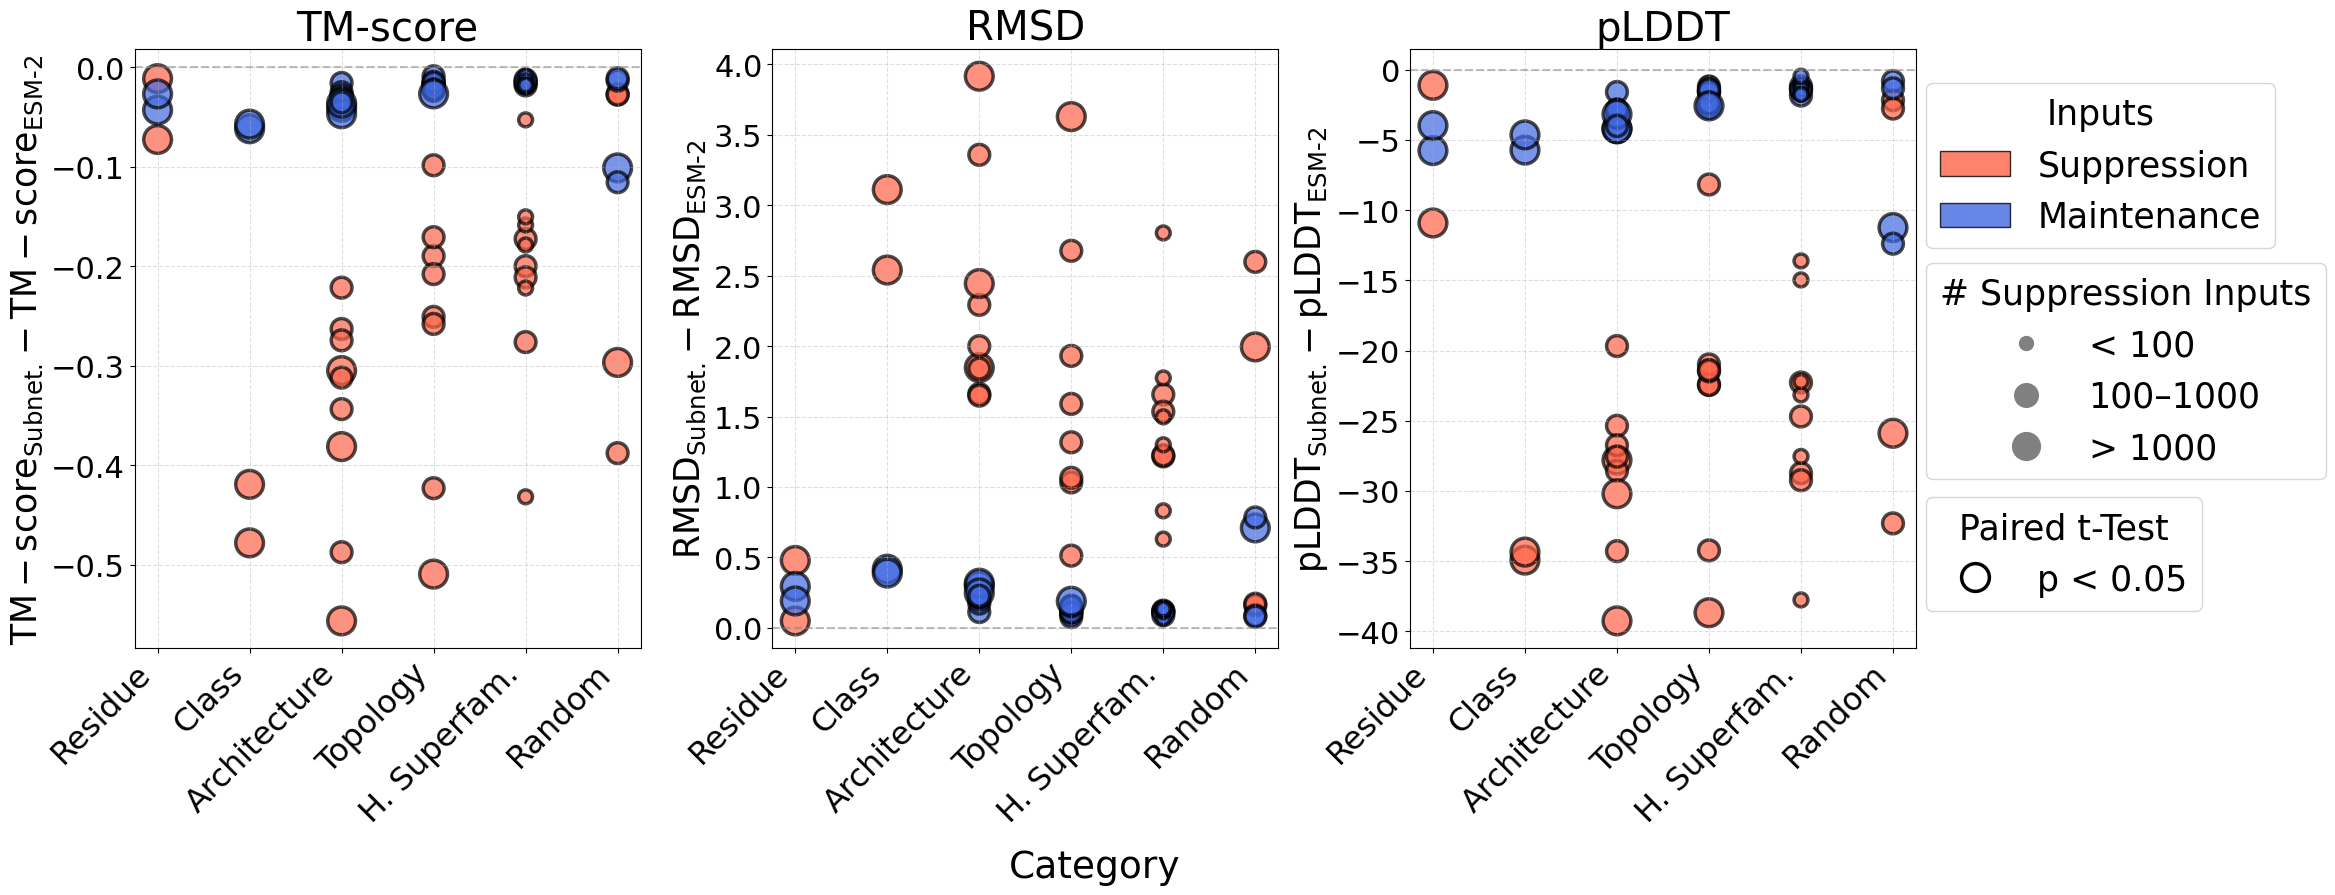

In [8]:
df_results_deltas = plot_metric_deltas_one_col(
    dataframes=df_list_all,
    labels=names_all,
    targets=targets_all,
    types=types_all,
    sizes=sizes_all,
    catnames=catnames_all,
    colors=["orange", "royalblue", "lightgray"],  # alpha, beta, mixed
    dpi=100,
    fontsize=25
)

### Plot Figure 3C (RMSD)

Loaded suppressed ids: 2000
Loaded suppressed ids: 1000
Loaded suppressed ids: 200
Loaded suppressed ids: 100


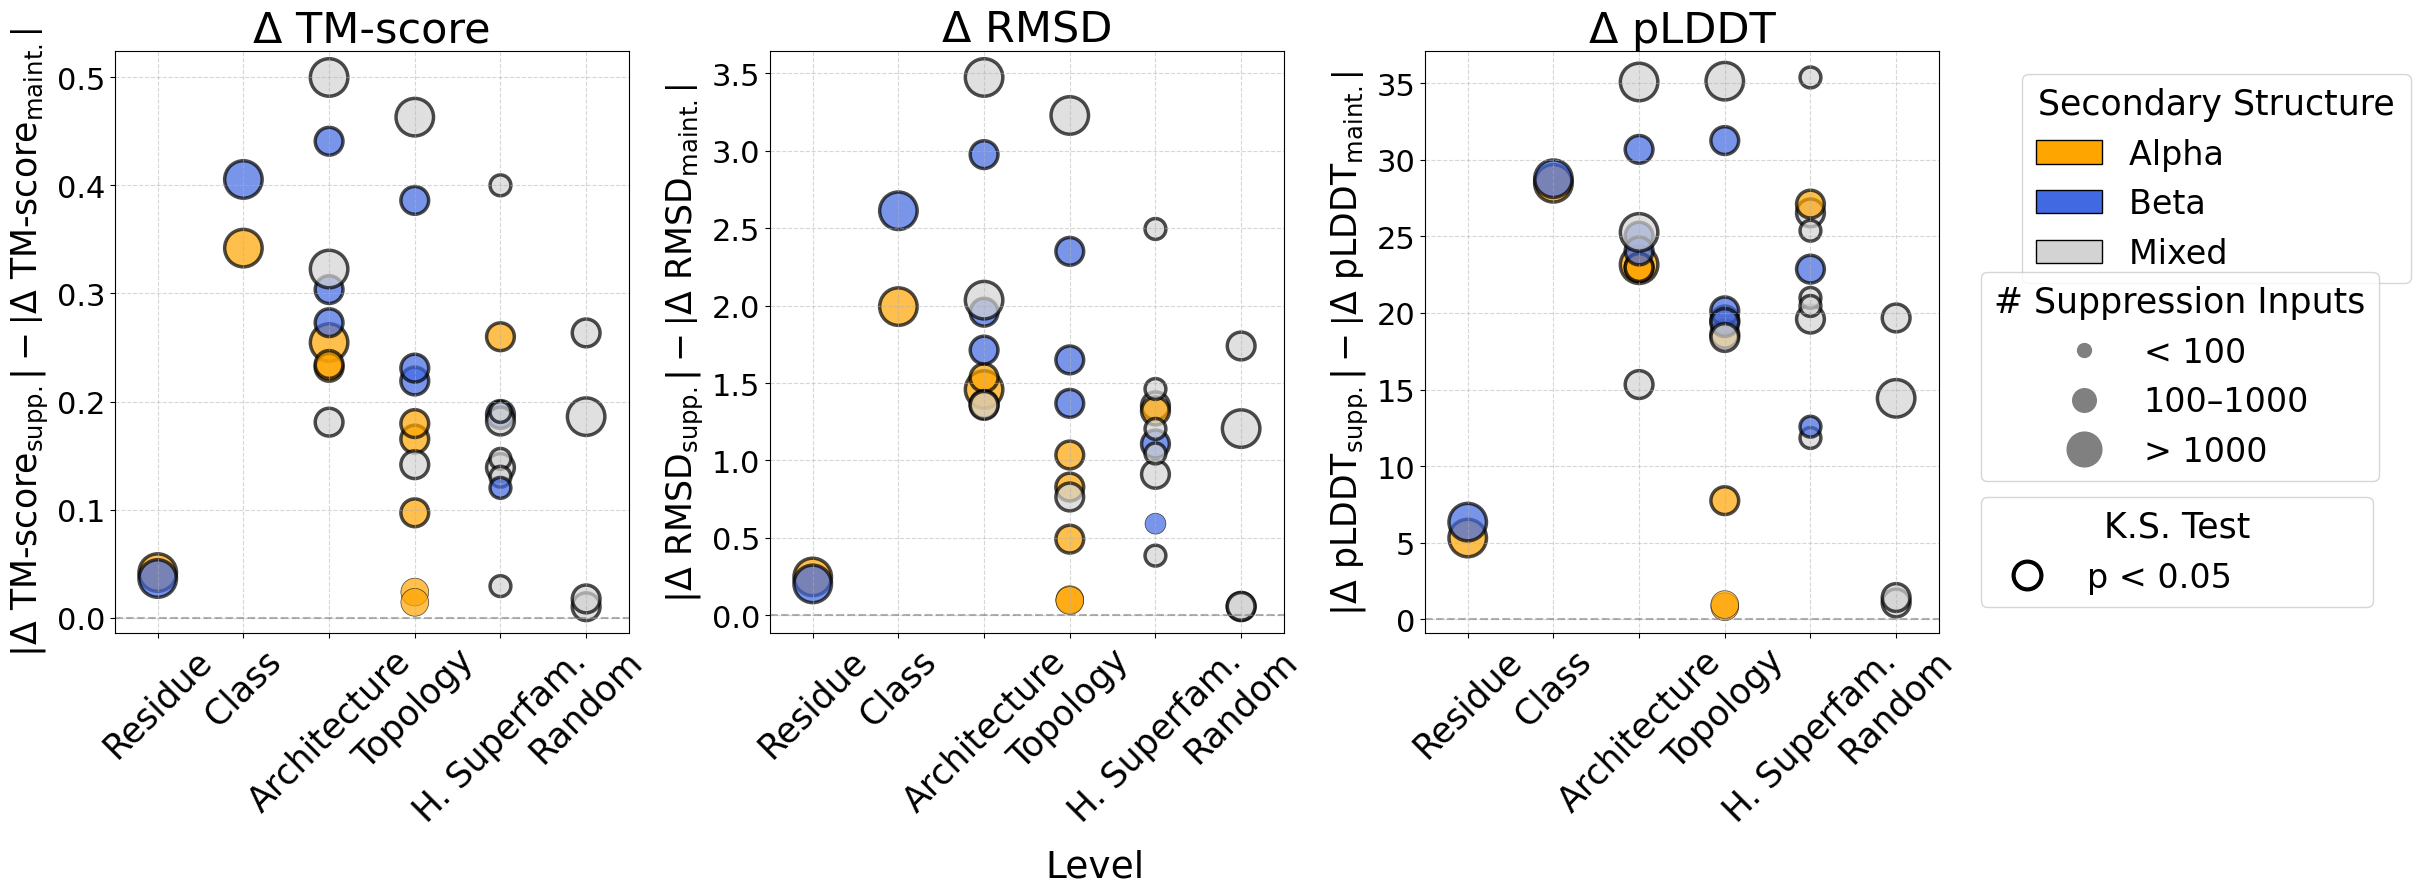

In [9]:
df_results_ks = plot_delta_model_vs_esm_with_ks(
    dataframes=df_list_all,
    labels=names_all,
    targets=targets_all,
    types=types_all,
    sizes=sizes_all,
    catnames=catnames_all,
    colors=["orange", "royalblue", "lightgray"],  # alpha, beta, mixed
    dpi=100,
    fontsize=25
)
